*Import libraries (tensorflow backend)*

# Chest X-Ray Pneumonia CNN Classification

In the following kernel I’ll try to identify correctly if Chest X-Ray image have Pneumonia . In order to do so I’ll use Chest X-Ray image dataset as input to a CNN (dataset is small <1000 - so we have to use data augmentation ) . After optimization process - optimal layers are 2 + 2 FC layers. I also run semi grid search on dropout , filter size etc.

Notes: 
1.Batch normalization layer causing reduce in accuracy + overfitting behavior ( unconstative behavior – accuracy is changing ~10% between different epochs) -if you manage to bypass it please let me know – I already tried : dropout , regulation l2 ,reduce model complexity , remove last batch to assure selfsame batches steps per epoch.
2.We need ~20 epochs since even without batch normalization it still have accuracy noise (~4% ) until epoch 12.


# Imports

In [1]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer
import os
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

Input_train_dir='../input/chest_xray/chest_xray/train'
Input_val_dir='../input/chest_xray/chest_xray/val'
Input_test_dir='../input/chest_xray/chest_xray/test'

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#  Show input files 

In [2]:

imgs=[]
for dirname, _, filenames in os.walk(Input_test_dir):
    i=0;
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if (i>10) & (i<35) :
          imgs.append(mpimg.imread(os.path.join(dirname, filename)))
        i+=1



../input/chest_xray/chest_xray/test/.DS_Store
../input/chest_xray/chest_xray/test/PNEUMONIA/person108_bacteria_507.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person88_bacteria_437.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person31_virus_70.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person78_bacteria_378.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person1620_virus_2807.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person104_bacteria_492.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person130_bacteria_623.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person42_virus_89.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person153_bacteria_726.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person172_bacteria_827.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person78_bacteria_385.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person161_bacteria_762.jpeg
../input/chest_xray/chest_xray/test/PNEUMONIA/person109_bacteria_517.jpeg
../inp

# Show 25 images

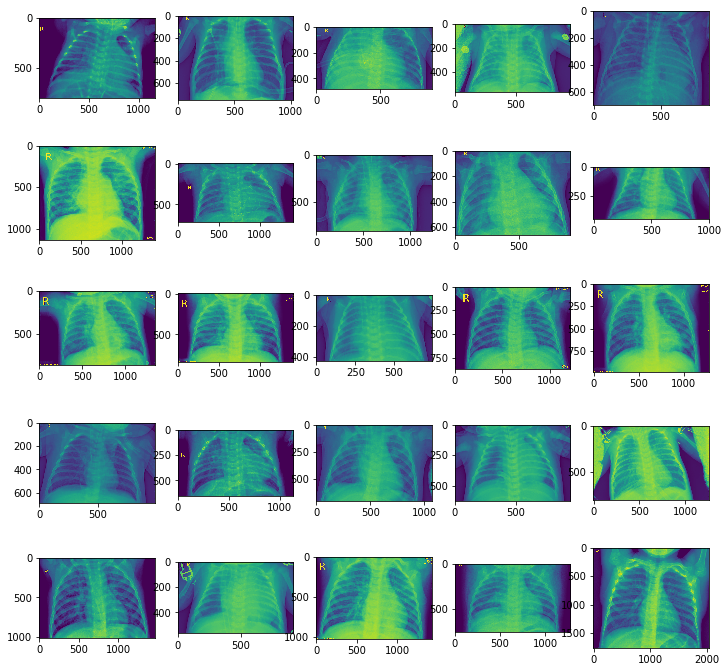

In [3]:
_, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

# Define CNN parameters

In [4]:
IMAGE_WIDTH    =64
IMAGE_HEIGHT   =64
IMAGE_CHANNELS =3
DROP_OUT_VALUE =0.15
POOL_SIZE      =2
epochs         = 20
batch_size      =32
filters        = (3,3)
IMAGE_SIZE     =(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SIZE_RGB     =(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)

# Define CNN model

In [5]:
model = Sequential()

model.add(Conv2D(32, filters, activation="relu", input_shape=IMAGE_SIZE_RGB))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (POOL_SIZE, POOL_SIZE)))
model.add(Dropout(DROP_OUT_VALUE))

model.add(Conv2D(32, filters, activation="relu"))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (POOL_SIZE, POOL_SIZE)))
model.add(Dropout(DROP_OUT_VALUE))


model.add(Flatten())
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'sigmoid', units = 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

# Define ImageDataGenerator (data augmentation)

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


# Takes the path for both train & test data from directory & generates batches of augmented data

In [7]:
training_set = train_datagen.flow_from_directory(Input_train_dir,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

val_set = test_datagen.flow_from_directory(Input_test_dir,
                                            target_size = IMAGE_SIZE,
                                            batch_size = batch_size,
                                            class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(Input_test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=batch_size,
                                                  class_mode='binary',  
                                                  shuffle=False)  

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Train the model 
 

In [8]:
history = model.fit_generator(training_set,
                         steps_per_epoch = 163, #163
                         epochs = epochs,
                         validation_data = val_set)
                         #validation_steps = 624
                          

Epoch 1/20
163/163 [==============================] - 139s 854ms/step - loss: 0.4593 - acc: 0.8010 - val_loss: 0.3771 - val_acc: 0.8510
Epoch 2/20
163/163 [==============================] - 98s 600ms/step - loss: 0.2734 - acc: 0.8848 - val_loss: 0.3507 - val_acc: 0.8349
Epoch 3/20
163/163 [==============================] - 112s 686ms/step - loss: 0.2306 - acc: 0.9032 - val_loss: 0.2874 - val_acc: 0.8734
Epoch 4/20
163/163 [==============================] - 112s 690ms/step - loss: 0.2210 - acc: 0.9124 - val_loss: 0.3092 - val_acc: 0.8638
Epoch 5/20
163/163 [==============================] - 103s 630ms/step - loss: 0.2086 - acc: 0.9183 - val_loss: 0.2639 - val_acc: 0.8942
Epoch 6/20
163/163 [==============================] - 114s 699ms/step - loss: 0.1934 - acc: 0.9218 - val_loss: 0.2948 - val_acc: 0.8782
Epoch 7/20
163/163 [==============================] - 106s 653ms/step - loss: 0.1865 - acc: 0.9260 - val_loss: 0.4559 - val_acc: 0.8285
Epoch 8/20
163/163 [=============================

# Show Accuracy & Loss of model per epoch

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


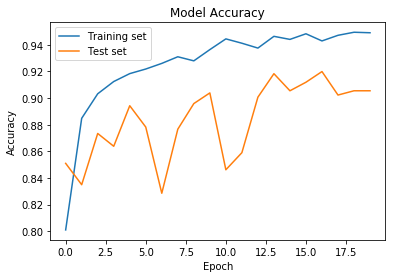

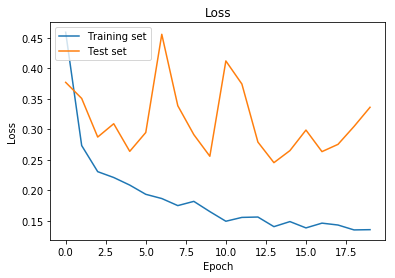

In [9]:
#Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()







# Calculate Test set confusion_matrix

In [10]:

probabilities = model.predict_generator(test_generator)


from sklearn.metrics import confusion_matrix

y_true = np.array([0] * 312 + [1] * 312)
y_pred = probabilities > 0.5

confusion_matrix(y_true, y_pred)

array([[183, 129],
       [  6, 306]])

# Get test set accuracy

In [11]:
#test_loss, test_accuracy=model.evaluate_generator(test_generator)
#print('Test accuracy={0:.5f}'.\
#format(accuracy))